In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import derivative # I found it!

# Question 1

In [2]:
data = pd.read_csv('reg.csv')

y = np.array(data['y'])
x = np.array(data.iloc[:, 1:])

In [13]:
def euclidean_norm(x: np.array) -> float:
    return np.sqrt(np.sum(x**2))

def regression_func(x: np.array, y: np.array, beta: np.array) -> float:
    n = len(x)
    return 1/n * np.sum((y - np.dot(x, beta))**2)

def numerical_gradient(f, beta, x, y, eps=1e-6):
    grad = np.zeros_like(beta)
    for i in range(len(beta)):
        beta_plus_eps = np.array(beta, copy=True)
        beta_minus_eps = np.array(beta, copy=True)
        beta_plus_eps[i] += eps
        beta_minus_eps[i] -= eps
        grad[i] = (f(x, y, beta_plus_eps) - f(x, y, beta_minus_eps)) / (2 * eps)
    return grad

def backtracking_line_search(f, x, y, beta, gradient, initial_lr=1.0, alpha=0.3, beta_param=0.9):
    lr = initial_lr
    while f(x, y, beta - lr * gradient) > f(x, y, beta) - alpha * lr * np.dot(gradient, gradient):
        lr *= beta_param
    return lr

def analytical_gradient(X: np.array, y: np.array, beta: np.array) -> np.array:
    n = len(y)
    grad = -2/n * np.dot(X.T, (y - np.dot(X, beta)))
    return grad

def stochastic_gradient_descent(
    x: np.array, 
    y: np.array,
    beta0: np.array = None, 
    batch_size: int = 1,
    max_iterations: int = 1000,
    epsilon: float = 1e-8,
    f: callable = None,
    exact_grad: bool = False
) -> np.array:
    obj_values = []  # To store objective function values

    if beta0 is None:
        beta0 = np.zeros(x.shape[1]) 
    beta = beta0
    
    for num_iterations in range(max_iterations):
        indices = np.random.choice(x.shape[0], batch_size, replace=False)
        x_batch = x[indices]
        y_batch = y[indices]
        
        if exact_grad:
            gradient = analytical_gradient(x_batch, y_batch, beta)
        else:
            gradient = numerical_gradient(f, beta, x_batch, y_batch)
        learning_rate = backtracking_line_search(f, x_batch, y_batch, beta, gradient)
        
        beta_prev = beta
        beta = beta - learning_rate * gradient
        
        obj_values.append(f(x_batch, y_batch, beta))

        if euclidean_norm(beta - beta_prev) < epsilon or euclidean_norm(gradient) < epsilon:
            break

    return beta, obj_values


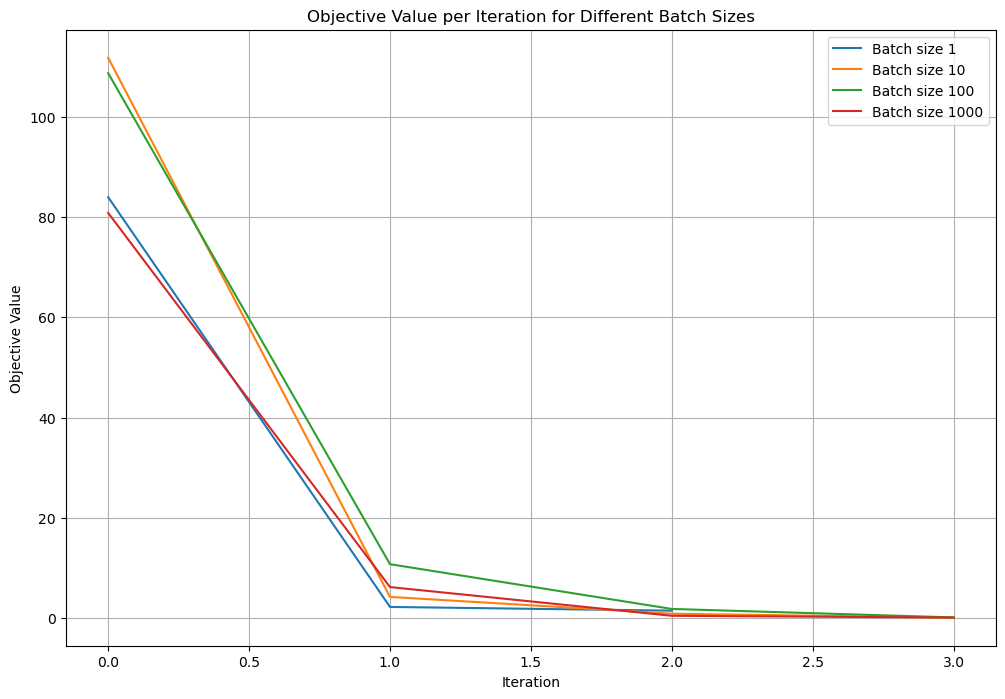

In [26]:
batch_sizes = [1, 10, 100, 1000]
results = {}

for B in batch_sizes:
    _, obj_values = stochastic_gradient_descent(
        x, y, batch_size=B, f=regression_func, epsilon=0.1, exact_grad=True
    )
    results[B] = obj_values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for B, obj_values in results.items():
    plt.plot(obj_values, label=f'Batch size {B}')

plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value per Iteration for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()


# Problem 2
1. We will show show the $L_0$ norm is not convex. Recall that $||B_0||_0 = \left\{ i : b_i \neq 0 \right\}$. So, let $x = \left\{ 1, 0 \right\}$ and $y = \left\{ 0, 1 \right\}$. Then, $||x||_0 = 1$ and $||y||_0 = 1$. However, $||\frac{x + y}{2}||_0 = 2$. Now, we have that $||\frac{1}{2}\cdot x + \frac{1}{2}\cdot y||_0 \leq \frac{1}{2}\cdot||x||_0 + \frac{1}{2}\cdot||y||_0$ is the definition of convexity. And so we have that 
$\begin{align}
||\frac{1}{2}\cdot x + \frac{1}{2}\cdot y||_0 &\leq \frac{1}{2}\cdot||x||_0 + \frac{1}{2}\cdot||y||_0 \\
2 & \leq \frac{1}{2} + \frac{1}{2} \\
\end{align}$
Which of course is not true. Thus, the $L_0$ norm is not convex.

2. We will use the result from the previous PSET to show that the $L_0$ norm is not a norm. Recall that we showed before that all norms are convex. Since the $L_0$ norm is not convex, it is not a norm.

3. We will now show that the $L_1$ norm is convex. To do this, we will show that the $L_1$ norm is a norm, which by the last PSET will imply convexity. 

    i. We will show that the $L_1$ norm is non-negative. This is clear since the absolute value of any number is non-negative.

    ii. We will show that the $L_1$ norm is zero if and only if the vector is the zero vector. This is clear since the absolute value of any number is zero if and only if the number is zero.

    iii. We will show that the $L_1$ norm satisfies the triangle inequality. This is clear since the absolute value of the sum of two numbers is less than or equal to the sum of the absolute values of the two numbers. That is $|a + b| \leq |a| + |b|$. If this is not immediately obvious, note that $|a + b| = |a| + |b|$ if $a$ and $b$ have the same sign, and $|a + b| = |a| - |b|$ if $a$ and $b$ have different signs. In either case, the triangle inequality holds.  
    
    iv. We will show that the $L_1$ norm is homogenous. This is clear since the absolute value of the product of a number and a vector is equal to the absolute value of the number times the absolute value of the vector.

Therefore, the $L_1$ norm is a norm, and thus convex.

4. We will now show that the $L_2$ norm is convex. To do this, we will show that the $L_2$ norm is a norm, which by the last PSET will imply convexity. 

    i. We will show that the $L_2$ norm is non-negative. This is clear since the square of any number is non-negative.

    ii. We will show that the $L_2$ norm is zero if and only if the vector is the zero vector. This is clear since the square of any number is zero if and only if the number is zero.

    iii. We will show that the $L_2$ norm satisfies the triangle inequality. 
    $\begin{align}
    ||x + y||_2^2 &= \sum_{i=1}^{n} (x_i + y_i)^2 \\
    &= \sum_{i=1}^{n} x_i^2 + 2x_iy_i + y_i^2 \\
    &= \sum_{i=1}^{n} x_i^2 + \sum_{i=1}^{n} 2x_iy_i + \sum_{i=1}^{n} y_i^2 \\
    & \leq  \vert\vert x \vert\vert_2^2 + 2\vert\vert x \vert\vert_2\vert\vert y \vert\vert_2 + \vert\vert y \vert\vert_2^2  && \text{Cauchy-Schwartz}\\ 
    \implies \vert\vert x + y \vert\vert_2^2 & \leq \left( \vert\vert x \vert\vert_2 + \vert\vert y \vert\vert_2 \right)^2 \\
    \end{align}$

    iv. We will show that the $L_2$ norm is homogenous. This is clear since the square of the product of a number and a vector is equal to the square of the number times the square of the vector. That is $||\alpha x||_2 = \alpha^2||x||_2$.

Therefore, the $L_2$ norm is a norm, and thus convex.

5. We will now show that $\alpha ||\beta||_1 + (1 - \alpha)||\beta||_2$ is convex. Note this is very easy. Since the $L_1$ and $L_2$ norms are convex, and since the sum of convex functions is convex (as we proved on the last PSET), we have that $\alpha ||\beta||_1 + (1 - \alpha)||\beta||_2$ is convex.

6. To find out which of these norms results in a convex regression problem for the objective $\min_{\beta} \frac{1}{n}\sum_{i = 1}^n \left(y_i - x_i\beta\right)^2 + \lambda h(\beta)$ is convex. First, now that we have already shown that the first part of the summand is convex. Since the sum of two convex functions is convex (as shown on the last PSET), it must be the case that the entire function is convex for the convex norms. Thus, the $L_1$ and $L_2$ norms result in a convex regression problem. Moreover, the elastic-net problem is also convex. However, the $L_0$ norm does not result in a convex regression problem since this function is not always convex. 

# Problem 3
## Part 1
*We do not have any graduate students in the class, so we will not be able to complete this part of the problem.*

## Part 2

# Problem 4

## Part 1

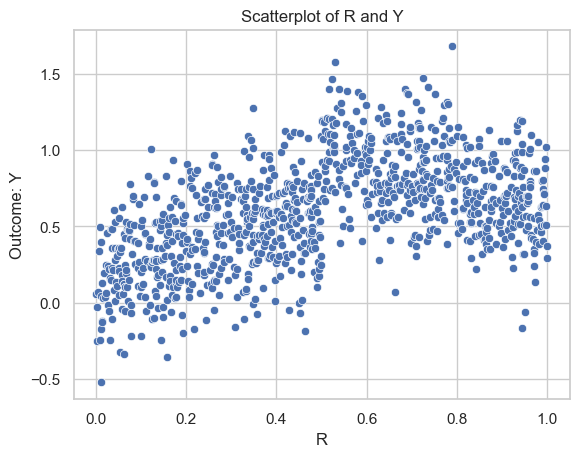

In [41]:
# we will load and plot the data - MV
rd_data = pd.read_csv('rd.csv')
rd_data = rd_data.drop(columns=['Unnamed: 0'])

# use seaborn to plot the data - MV
sns.set(style="whitegrid")
ax = sns.scatterplot(x = rd_data['R'], y = rd_data['Y'])
ax.set(xlabel='R', ylabel='Outcome: Y')
plt.title('Scatterplot of R and Y')
plt.show()

Yes, you can see a discontinuity at 0.5. 

## Part 2
I kind of like the idea of running the regression over the entire dataset to either side of the discontinuity. This way, we can see if the regression is different on either side of the discontinuity.

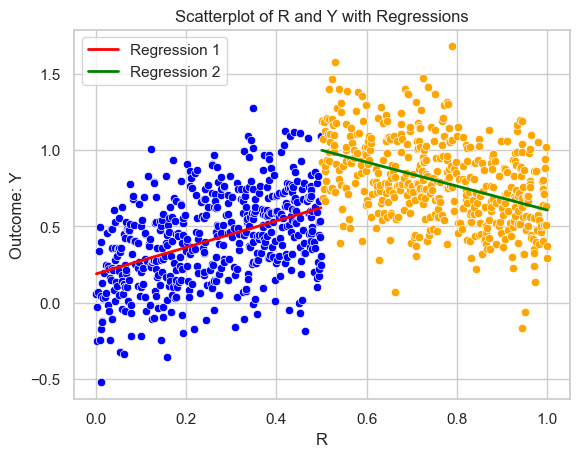

In [49]:
# run the regressions on either side of 0.5 - MV

# create the dataframes - MV
rd_data_1 = rd_data[rd_data['R'] <= 0.5]
rd_data_2 = rd_data[rd_data['R'] > 0.5]

# run the regressions - MV
regression_1 = np.polyfit(rd_data_1['R'], rd_data_1['Y'], 1)
regression_2 = np.polyfit(rd_data_2['R'], rd_data_2['Y'], 1)

# plot the data and the regressions - MV
sns.set(style="whitegrid")
ax = sns.scatterplot(x = rd_data_1['R'], y = rd_data_1['Y'], color = 'blue')
ax = sns.scatterplot(x = rd_data_2['R'], y = rd_data_2['Y'], color = 'orange')
ax.set(xlabel='R', ylabel='Outcome: Y')
plt.plot(rd_data_1['R'], np.polyval(regression_1, rd_data_1['R']), color = 'red', label = 'Regression 1', linewidth = 2)
plt.plot(rd_data_2['R'], np.polyval(regression_2, rd_data_2['R']), color = 'green', label = 'Regression 2', linewidth = 2)
plt.title('Scatterplot of R and Y with Regressions')
plt.legend()
plt.show()

## Part 3
To estimate the treatment effect, we will find the jump at 0.5. 

In [57]:
# Estimating the jump
jump = (regression_2[1] + regression_2[0] * 0.5) - (regression_1[1] + regression_1[0] * 0.5) # Polyfit returns the slope first - MV
print(f'The estimated treatment affect at the cutoff is {jump}')

The estimated jump is 0.3761150400692135


## Part 4